Implements billiard dynamics of many spherical particles in arbitrary dimension with custom particle-wall and particle-particle collision maps using either standard CPU serial mode or accelerated parallel mode using NVIDIA GPU with numba cuda.

Dr. Scott Cook - Tarleton State Univ - Dept of Mathematics

Release notes 2018/04/14
- Simulation can run entirely in "serial" mode without GPU hardware (or even without gpu_defs.py).
- "Parallel" mode uses most of the same code as serial.  Main difference is that computation of particle-particle collision times is done on GPU, since that is the $O(n^2)$ calculation ($n$=number of particles).
- Consider computing particle-wall collision time on GPU in the future.  But that is $O(n)$, so it is not clear how much speed up that will provide.
- "Parallel" mode can run with or without verification against CPU using the "check_gpu_against_cpu" variable.  Verification adds significant time and should be used for code validation and debugging.
- Animations rely on FFMPEG or equivalent.

In [1]:
%run -i billiard_defs.py
%run -i chambers.py

# modes = ['serial', 'parallel']
# modes = ['parallel']
modes = ['serial']
check_gpu_against_cpu = True#False

run_time = {key:[] for key in modes}
pos = {key:[] for key in modes}

max_steps = 100
max_records = None
try:
    rec_period = int(np.ceil(max_steps / max_records))
except:
    rec_period = 1
if (rec_period < 1) or (rec_period is np.inf):
    rec_period = 1

NP = np.arange(1,2,1) * sqrt_threads_per_block_max
for num_part in NP:
    for mode in modes:
        seed = 20
        rnd = np.random.RandomState(seed)
        dim = 2
        
#         cell_size = np.asarray([20.0, 10.0])
#         wall = box(cell_size)
#         wall = sinai(cell_size, scatter_radius)
#         wall = lorentz_rectangle(cell_size, scatter_radius)

        scatter_radius = 3.0
        particle_radius = 0.2
        horizon_factor = 0.8
        wall, cell_size = lorentz_hexagonal(scatter_radius, particle_radius, horizon_factor)

        for w in wall[4:]:
            w.collision_law = PW_NoSlipLaw()
        
        part = Particles()        
        
        part.collision_law=PP_NoSlipLaw()
        part.mass[:] = 1
        part.gamma[:] = 0.1

        try:
            part.radius[:] = particle_radius
        except:
            ## compute radius so that particles take up a fixed proportion of the volume of the box
            density = 0.1
            V_box = np.prod(cell_size)
            try:
                V_box -= np.pi*scatter_radius**2
            except:
                pass
            V_part_box = density * V_box / num_part  # volume of little box each particle must fit into
            part.radius[:] = (V_part_box)**(1/dim) / 2
        
        
        start = timer()
        initialize(wall, part)
        if mode == 'parallel':
            %run -i gpu_defs.py
            load_gpu(part)
        
        for step in range(max_steps):
            next_state(part)
            part.check()
            if mode == 'parallel':
                update_gpu(part)

            if step % rec_period == 0:        
#                 print('num_part = {}, step = {}, mode = {}'.format(part.num, step, mode))
                part.record_state()
                
        part.clean_up()
        elapsed = timer() - start
        print('Done!! #Particles = {}, Steps = {}, Sim Time = {:2f}, Elapsed Time = {:2f}\n'.format(part.num, step+1, part.t_hist[-1], elapsed))
        run_time[mode].append(elapsed)
        pos[mode].append(part.pos_hist.copy())
#     print(pos['serial'][-1] - pos['parallel'][-1])
#     assert np.allclose(pos['serial'][-1], pos['parallel'][-1], rtol=0.05)

Done!! #Particles = 1, Steps = 100, Sim Time = 126.258532, Elapsed Time = 0.315658



In [2]:
%run -i visualize.py
%matplotlib inline
if hasattr(part, 're_pos') == False:
    smoother(part)#, min_frames=1)

interactive_plot()


# anim = animate()#frames = 30)

# diplays video in motebook
# display(HTML(anim.to_jshtml()))   

#save animation as mp4
# fname = 'billiards.mp4'
# anim.save(filename=fname)
# play_video('billiards.mp4')

smoothing


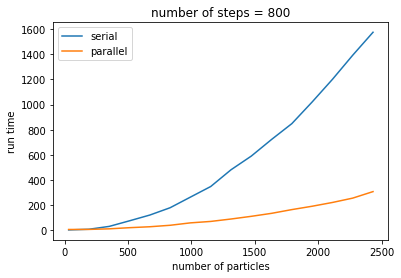

In [2]:
w = min([len(t) for k,t in run_time.items()])
for mode, time in run_time.items():
    plt.plot(NP[:w], run_time[mode][:w], label=mode)
plt.legend()
plt.xlabel('number of particles')
plt.ylabel('run time')
plt.title('number of steps = {}'.format(max_steps))
plt.show()